In [ ]:
#| default_exp init

## Initialization 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)
     
plt.style.use('dark_background')

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

Create our standard `get_model` function to create a convolutional NN.

In [ ]:
def get_model():
    # 8-16-32-64-10-Flatten
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

In [ ]:
# add callbacks for Device, Progress and learn finder
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB(gamma=1.1)]
# create Momentum learner
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)

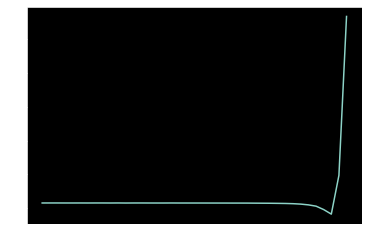

In [ ]:
# use `.lr_find` with gamma 1.1 and lr 1e-2
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

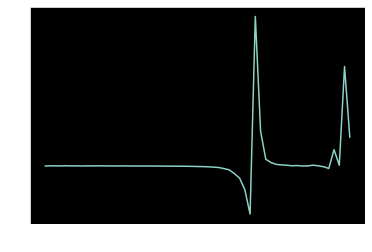

In [ ]:
learn.fit(1)

We see that is is even hard to make a learn finder work correctly.

In [ ]:
# create multiclass accuracy metric
metrics = MetricsCB(accuracy=MulticlassAccuracy())
# create activation stats, filter on nn.ReLU
astats = ActivationStats(fc.risinstance(nn.ReLU))
# create callbacks for device, metrics, progress and activation stats
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
# create momentum learner with lr 0.2
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.169,2.219,0,train
0.371,1.628,0,eval


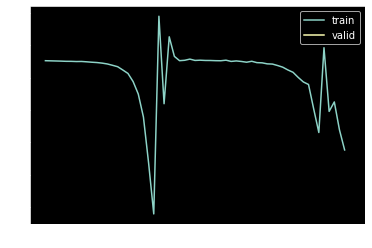

In [ ]:
learn.fit(1)

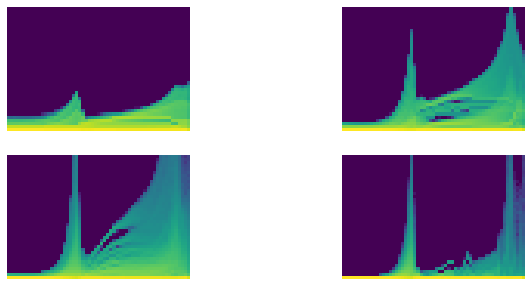

In [ ]:
astats.color_dim()

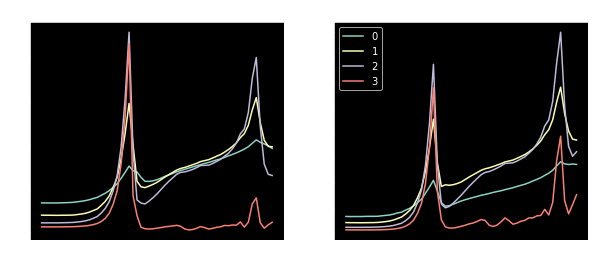

In [ ]:
astats.plot_stats()

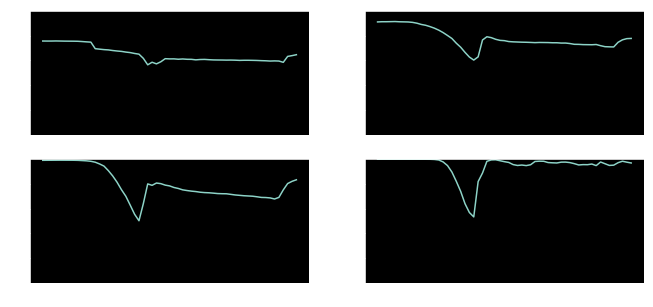

In [ ]:
astats.dead_chart()

On pictures above we see the problem - activation spikes and dies right after.

## Jupyter Lab Optimization

Jupyer Lab aside. JL stores the results of some previous calcualtions for our convenience. But that also means that if we calulate a huge cuda tensor, it stays allocated.

Another note is if we run into cuda out of memory error, all the traceback to it is stored as well.

In [ ]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''
     

In [ ]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')
     

In [ ]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()
     

## Glorot/Xavier init

We can see general problem with random initializaion below:

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x@torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

After 50 layers the result is `nans` everywhere. So maybe the scale of our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem—the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left with zeros everywhere:

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x@(torch.randn(100, 100) * 0.01)
x[0:5, 0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so that the standard deviation of our activations stays at 1. We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). The right scale for a given layer is $1/\sqrt{n_{in}}$, where $n_{in}$ represents the number of inputs.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = x@(torch.randn(100, 100) * 1 / math.sqrt(100))
x[0:5, 0:5]

tensor([[ 0.13,  0.63, -0.40,  0.66, -1.01],
        [-0.23, -0.41,  0.02, -0.09, -0.28],
        [-0.79,  0.03, -0.01,  1.90, -0.29],
        [-0.30, -0.22, -0.19,  0.08, -0.19],
        [ 0.76,  0.70,  0.21, -0.37, -1.15]])

## Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g.:

In [ ]:
t = torch.tensor([1., 2., 4., 18.])

In [ ]:
m = t.mean(); m

tensor(6.25)

Simply taking an average over difference between numbers and their mean gives as zero by design.

In [ ]:
(t-m).mean()

tensor(0.)

We can either calculate mean of squared differences and mean of absolute differences.

In [ ]:
((t-m)**2).mean()

tensor(47.19)

In [ ]:
(t-m).abs().mean()

tensor(5.88)

Note, that if we use the first way, we need to take a square root to set variance to our original scale (standard deviation).

In [ ]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

Useful thing to note about variance:

In [ ]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

The latter is generally much easier to work with. In particular, you only have to track two things: the sum of the data, and the sum of squares of the data. Whereas in the first form you actually have to go thru all the data twice (once to calculate the mean, once to calculate the differences). $$\operatorname{E}\left[X^2 \right] - \operatorname{E}[X]^2$$

### Covariance

Now let's look a t covariance: $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$

In [ ]:
t

tensor([ 1.,  2.,  4., 18.])

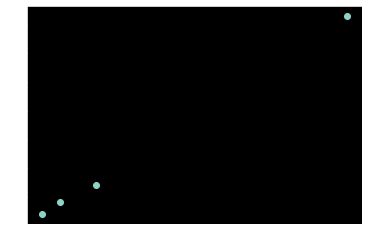

In [ ]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10+0.95

plt.scatter(t, u);

In [ ]:
prod = (t-t.mean())*(u-u.mean()); prod

tensor([ 54.64,  35.05,  12.07, 282.21])

In [ ]:
prod.mean()

tensor(95.99)

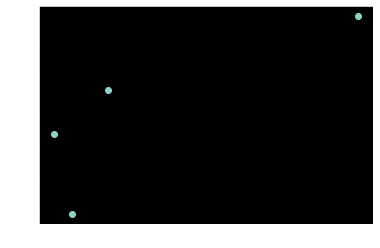

In [ ]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [ ]:
((t-t.mean())*(v-v.mean())).mean()

tensor(6.13)

In [ ]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(6.13)

Finally, here is the Pearson correlation coefficient:
$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

In [ ]:
cov / (t.std() * v.std())

tensor(0.62)

## Xavier init derivation

In [ ]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.05), tensor(1.03))

Let's calculate how mean and squared mean will change after calculating matrix multiplication. To avoid getting weird weights by chance, we will run this calculation 100 times and average mean and squared mean

In [ ]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean/100, sqr/100

(0.011671690195798874, 101.63312271118164)

Now that looks very close to the dimension of our matrix 100. And that's no coincidence! When you compute y, you sum 100 product of one element of a by one element of x. So what's the mean and the standard deviation of such a product? We can show mathematically that as long as the elements in a and the elements in `x` are independent, the mean is 0 and the std is 1. This can also be seen experimentally:

In [ ]:
mean, sqr = 0.,0.
for i in range(10_000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr += y.pow(2).item()
mean / 10_000, sqr / 10_000

(0.0008121221107874589, 0.9861112495086729)

Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence `math.sqrt(100)` being our magic number. If we scale the weights of the matrix and divide them by this `math.sqrt(100)`, it will give us a y of scale 1

## Kaiming / He init

Let's create a simple example and apply Glorot initializaton to check mean and variance of activatons for our layer.

In [ ]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [ ]:
from math import sqrt

In [ ]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [ ]:
def lin(x,w,b): return x @ w + b

In [ ]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.01), tensor(0.99))

Great, everything seems like we wanted. Except we did not account for ReLU activation function. Let's calculate it as well.

In [ ]:
def relu(x): return x.clamp_min(0.)

In [ ]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.40), tensor(0.58))

Ooops, things got worse. Let's check how our activations will behave in a deeper NN.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

Activations got squished to zero...

In [Delving Deep into Rectifiers: Surpassing Human-Level Performance] https://arxiv.org/abs/1502.01852 Kaiming He et al. show that we should use the following scale instead: 
$\sqrt{2/n_{in}}$, where $n_{in}$ is the number of inputs of our model.

In [ ]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * math.sqrt(2/100)))
x[0:5, 0:5]

tensor([[0.00, 0.42, 0.06, 0.07, 0.00],
        [0.00, 0.35, 0.05, 0.03, 0.00],
        [0.00, 0.38, 0.02, 0.04, 0.00],
        [0.00, 0.53, 0.08, 0.08, 0.00],
        [0.00, 0.20, 0.02, 0.01, 0.00]])

## Applying an init function

In [ ]:
model = get_model()
model.apply(lambda l: print(type(l).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [ ]:
def init_weights(m):
    if isinstance(m ,(nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [ ]:
model.apply(init_weights);

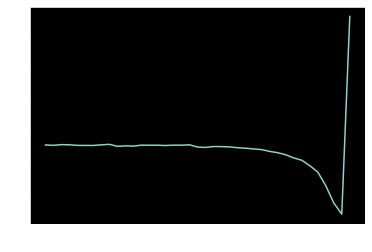

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-5, cbs=[DeviceCB()])
learn.fit(3, cbs=LRFinderCB())

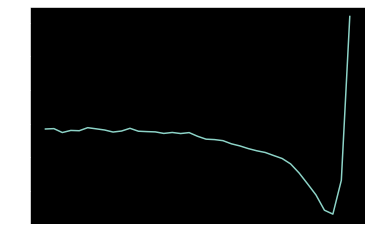

In [ ]:
model = get_model()
model.apply(init_weights);
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [ ]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), 
                        dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.585,1.233,0,train
0.777,0.603,0,eval
0.818,0.488,1,train
0.833,0.454,1,eval
0.843,0.424,2,train
0.848,0.411,2,eval


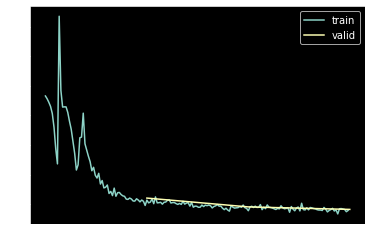

In [ ]:
learn.fit(3)

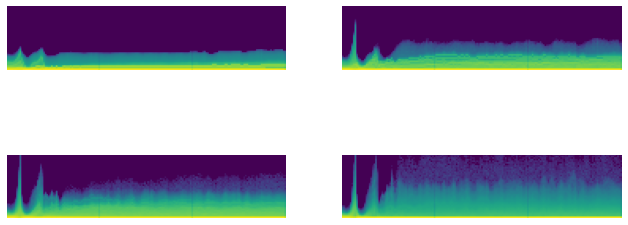

In [ ]:
astats.color_dim()

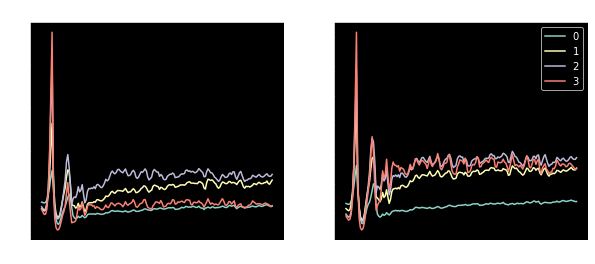

In [ ]:
astats.plot_stats()

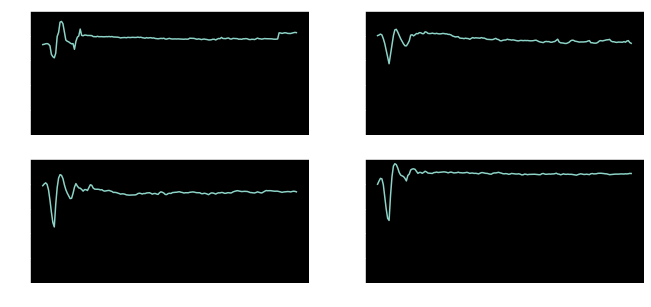

In [ ]:
astats.dead_chart()

Judging from the graphs above, we still see that most of the activations are around zero, even though we have used kaiming init. Why is that so?

## Input normalization

We did not normalize our inputs!

In [ ]:
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.29), tensor(0.35))

In [ ]:
#| export 
class BatchTransformCB(Callback):
    # tfm can be nn.Sequential in order to combine several transforms
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
    
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            # transform batch during the `before_batch` stage
            learn.batch = self.tfm(learn.batch)

In [ ]:
# function to normalize x part of a batch
def _norm(b): return (b[0]-xmean)/xstd, b[1]
norm = BatchTransformCB(_norm)

accuracy,loss,epoch,train
0.551,1.388,0,train
0.756,0.633,0,eval
0.811,0.510,1,train
0.819,0.489,1,eval
0.843,0.429,2,train
0.844,0.428,2,eval


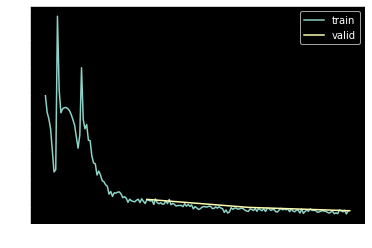

In [ ]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights),
                        dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])

learn.fit(3)

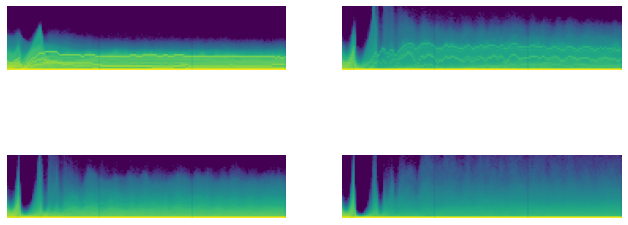

In [ ]:
astats.color_dim()

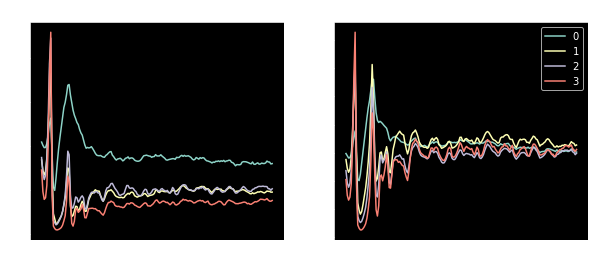

In [ ]:
astats.plot_stats()

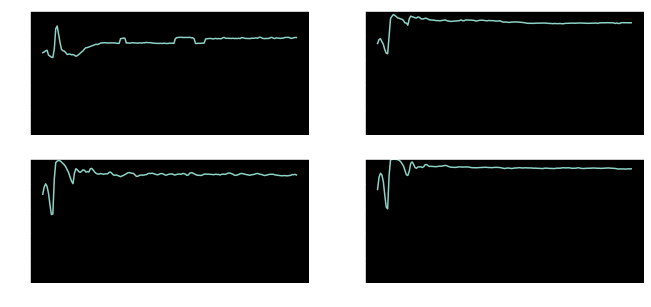

In [ ]:
astats.dead_chart()

We can avoid using callbacks and employ HG `with_transform` method.

In [ ]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
# grab a batch of x and y data
xb,yb = next(iter(dls.train))

In [ ]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.00))

## General ReLU

ReLU seems to be fundamentally incompatible with the idea of perfectly calibrated weights because it discards all of the values below zero. Thus it is impossible for ReLU to have mean of zero unless all of the activations are zero!

We can come up with a more advanced version of a ReLU that will subtract specific value from a ReLU and pull it down.

In [ ]:
#| export 
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        fc.store_attr()
        
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

Let's introduce a simple function plotting function.

In [ ]:
#| export
def plot_func(f, start=-5, end=5, steps=100):
    # setup x
    x = torch.linspace(start,end,steps)
    # plot function
    plt.plot(x, f(x))
    # setup grid lines
    plt.grid(True, which='both', ls='--')
    # setup vertical and horizontal lines at (0,0)
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

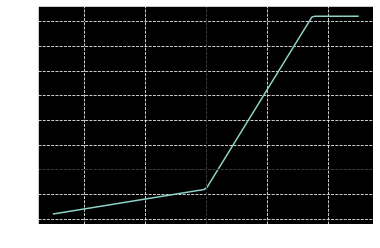

In [ ]:
plot_func(GeneralRelu(leak=0.1, sub=0.4, maxv=3.1))

In [ ]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, kernel_size=3, stride = stride, padding = ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [ ]:
def get_model(act=nn.ReLU, nfs=None):
    # setup number of filters (1,8,16,32,64)
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    # create conv layers from filters
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    # wrap into Sequential model adding final layer and flatten. Then move to device
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [ ]:
#| export
def init_weights(m, leaky=0.):
    # init kaiming normal for conv layers
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): 
        init.kaiming_normal_(m.weight, a=leaky)

In [ ]:
# activation for general relu
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
# put device, metrics, progress and stats into cbs
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
# init weights for relu
iw = partial(init_weights, leaky=0.1)

In [ ]:
astats??

Type:        ActivationStats
String form: <miniai.activations.ActivationStats object>
File:        /notebooks/fastai-p2/miniai/activations.py
Source:     
class ActivationStats(HooksCallback):
    # super init
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)
    
    
    def color_dim(self, figsize=(11,5)):
        # grab grid based on length of stats
        fig, axes = get_grid(len(self), figsize=figsize)
        # plot colorful dims plots for each hook
        for ax, h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')
      
    
    def dead_chart(self, figsize=(11,5)):
        # grab grid based on length of stats
        fig, axes = get_grid(len(self), figsize=figsize)
        # plot dead_chart (min(h)
        for ax, h in zip(axes.flat, self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)
    
    
    def plot_stats(self, figsize=(10,4)):
        # create subplots and plot means and std
       

In [ ]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.775,0.625,0,train
0.846,0.419,0,eval
0.868,0.361,1,train
0.861,0.373,1,eval
0.880,0.325,2,train
0.868,0.361,2,eval


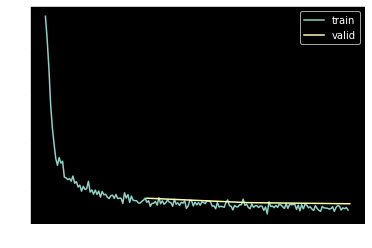

In [ ]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

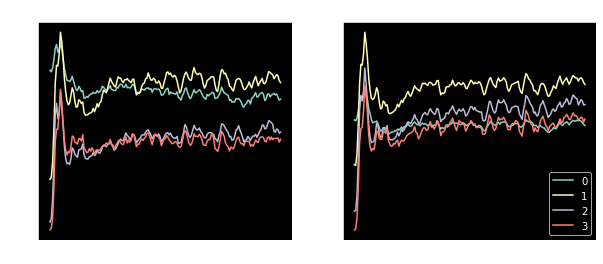

In [ ]:
astats.plot_stats()

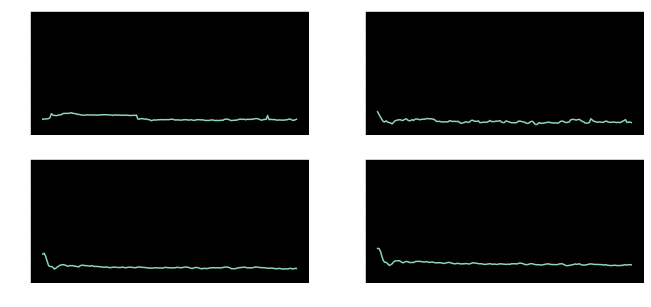

In [ ]:
astats.dead_chart()

Much better. Now mean is roughly 0, stds are around 1 and activations are generally not zero.

## LSUV

[All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf) introduces Layer-wise Sequential Unit-Variance (LSUV). Basically we take one batch, feed it though the net and calibrate weights to achieve zero mean and unit variance.

In [ ]:
#| export 
def _lsuv_stats(hook, # hook object
                mod, # module to hook onto
                inp, # input to a layer (x or output from previous layer)
                outp # output - activations of a model's layer
               ):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()
    
def lsuv_init(model,
              m, # list of output modules
              m_in, # list of input modules
              xb # batch
             ):
    # create a hook to a module using `_lsuv_stats` f-n
    # import ipdb; ipdb.set_trace()
    h = Hook(m, _lsuv_stats)
    # without grad calculation update weights and biases until std of layer's activations is 1 and mean is 0
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [ ]:
??Hook

Init signature: Hook(m, f)
Docstring:      <no docstring>
Source:        
class Hook:
    def __init__(self, 
                 m, # module that we a hooking
                 f # function
                ):
        # register hook with a function on a layer (module)
        self.hook = m.register_forward_hook(partial(f, self))
    # remove hook
    def remove(self): self.hook.remove()
    # del method
    def __del__(self): self.remove()
File:           /notebooks/fastai-p2/miniai/activations.py
Type:           type
Subclasses:     


In [ ]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [ ]:
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [ ]:
# apply lsuv_init in a loop to each of the model's pair of input and output layers.
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.781,0.607,0,train
0.845,0.430,0,eval
0.862,0.375,1,train
0.860,0.383,1,eval
0.876,0.334,2,train
0.868,0.358,2,eval


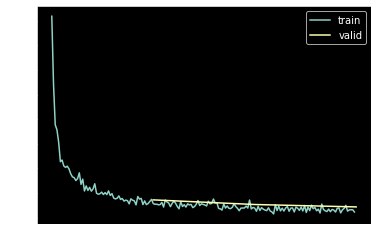

In [ ]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## Batch Normalization

Even if we initialize all of our layers correctly, the weights change during training and this changes their distribution. We need to reduce the learning rate to account for it. Another option is to normalize weights during training - this is what BN tries to achieve.

Sergey Ioffe and Christian Szegedy released ["Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift"](https://arxiv.org/abs/1502.03167) in 2015, saying:

>Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. This slows down the training by requiring lower learning rates and careful parameter initialization... We refer to this phenomenon as internal covariate shift, and address the problem by normalizing layer inputs.

Their proposal is:

>Making normalization a part of the model architecture and performing the normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates and be less careful about initialization.

## LayerNorm

So basically we normalize all of our weights to have mean 0 and variance 1 and then we allow the model to `unshift` itself. Maybe the model does not want to be normalized and have zero mean and unit variance. Note, that we unnormalize the date using just two parameters - `self.mult` and `self.add`. This is a vast simplification to the NN because before the model had to make this normalization by adjusting every single number in the weight matrix. Now we just have two of them.

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        # multiplicative factor
        self.mult = nn.Parameter(tensor(1.0))
        # shift factor
        self.add = nn.Parameter(tensor(0.0))
        
    def forward(self, x):
        # batch x channel x height x width
        # import ipdb; ipdb.set_trace()
        # calculate mean and variance over batch dimension (for each input)
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        # normalizing the batch (or rather input to each subsequent layer)
        x = (x-m)/(v+self.eps).sqrt()
        # SGD can change the normalization
        return x*self.mult + self.add

In [ ]:
b = next(iter(dls.train))
b[0].shape

torch.Size([1024, 1, 28, 28])

In [ ]:
b[0].mean((1,2,3), keepdim=True).shape

torch.Size([1024, 1, 1, 1])

In [ ]:
#| export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    # if Normalization is of type BN, than we don't need bias
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    # conv2d layer
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    # append normalization layer if needed
    if norm: layers.append(norm(nf))
    # append activation layer if needed
    if act: layers.append(act())
    # pull all layers into Sequential
    return nn.Sequential(*layers)          

In [ ]:
#| export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    # standard number of filters ([1,8,16,32,64])
    if nfs is None: nfs = [1,8,16,32,64]
    # conv layers for given filters
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    #  pull together with final layers without activation of normalization. Then flatten and move to device
    return nn.Sequential(*layers, conv(nfs[-1], 10,act=None, norm=False, bias=True), 
                         nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.781,0.606,0,train
0.846,0.422,0,eval
0.864,0.370,1,train
0.860,0.377,1,eval
0.882,0.321,2,train
0.866,0.362,2,eval


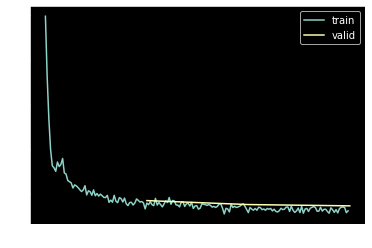

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

## BatchNorm

Now let's move to batch norm

In [ ]:
torch.lerp(tensor(5.), tensor(15.), 0.1), 5*0.9+15*0.1

(tensor(6.), 6.0)

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom, self.eps = mom, eps
        # create shift (adds) and scale (mults) factors for each channel / filter
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        # similar to register parameters but does not compute grad
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
    
    def update_stats(self, x):
        # compute means and variances over channels / filters
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        # take existing means and vars per channels / filters and update based on
        # current minibatch mean and var
        # sel.mom is how much of the second variable to take
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
        
    def forward(self, x):
        # update mults and adds during training
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        # during inference use calculated stats during training
        else: m,v = self.means, self.vars
        # update batch values
        x = (x-m)/(v+self.eps).sqrt()
        # apply shift and scale (trainable parameters)
        return x*self.mults + self.adds

accuracy,loss,epoch,train
0.799,0.551,0,train
0.834,0.518,0,eval
0.875,0.341,1,train
0.868,0.365,1,eval
0.886,0.306,2,train
0.871,0.362,2,eval


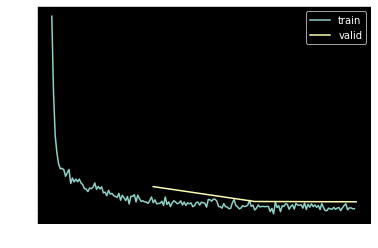

In [ ]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

![""](https://raw.githubusercontent.com/Iamalos/course22p2/df9323235bc395b5c2f58a3d08b83761947b9b93/nbs/images/norms.png)

## Towards 90%

First reduce the batch size to 256. Then use PyTorch BN norm layer, lr=0.2, cbs and weights initialization

In [ ]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.837,0.450,0,train
0.867,0.365,0,eval
0.884,0.317,1,train
0.863,0.375,1,eval
0.897,0.280,2,train
0.887,0.309,2,eval


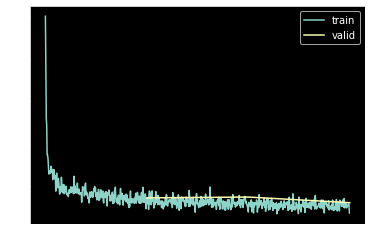

In [ ]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

Now reduce weights to 0.05

accuracy,loss,epoch,train
0.919,0.224,0,train
0.896,0.286,0,eval
0.922,0.211,1,train
0.897,0.282,1,eval


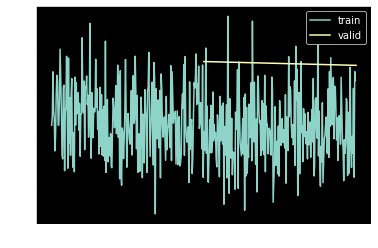

In [ ]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()

/root/.local/lib/python3.9/site-packages/nbdev/export.py:54: UserWarning: Notebook '/notebooks/fastai-p2/nbs/12_accel_sgd.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
